In [1]:
import io
import os
import sys
import csv
import gzip
import time
import json
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
import sqlite3
from PIL import Image
import matplotlib.pyplot as plt
from plotnine import *
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import itertools
import collections
import patchworklib as pw
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus
from lcwgsus.variables import *
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

/gpfs3/well/band/users/rbx225/GAMCC


<Figure size 100x100 with 0 Axes>

In [2]:
configfile = "/well/band/users/rbx225/GAMCC/pipelines/config.json"
with open(configfile, 'r') as file:
    data = json.load(file)
    
imp_dirs = data['imputation_dir']
imp_dirs = imp_dirs[:6] + imp_dirs[7:] # Temporarily remove HRC 

mini_imp_dirs = data['mini_imputation_dir']
lr_imp_dirs = data['lr_imputation_dir']
sr_imp_dirs = data['sr_imputation_dir']

outdir = '/well/band/users/rbx225/GAMCC/graphs/paper/'
save_fig = True

imp_dirs

['results/imputation_comparison/vanilla/lc_oneKG--chip--typed/',
 'results/imputation_comparison/vanilla/lc_oneKG--chip--typed_high_info/',
 'results/imputation_comparison/vanilla/chip_oneKG--hc--snps_gw/',
 'results/imputation_comparison/vanilla/lc_oneKG--hc--snps_gw/',
 'results/imputation_comparison/vanilla/chip_topmed--hc--snps_gw/',
 'results/imputation_comparison/vanilla/lc_oneKG_oneKG--hc--snps_gw/',
 'results/imputation_comparison/vanilla/lc_oneKG_topmed--hc--snps_gw/',
 'results/imputation_comparison/vanilla/lc_oneKG_typed_oneKG--hc--snps_gw/',
 'results/imputation_comparison/vanilla/lc_oneKG_typed_topmed--hc--snps_gw/',
 'results/imputation_comparison/vanilla/lc_oneKG_highConfidence_topmed--hc--snps_gw/',
 'results/imputation_comparison/vanilla/lc_malariaGen_v1_b38_topmed--hc--snps_gw/',
 'results/imputation_comparison/vanilla/lc_malariaGen_v3_b38_topmed--hc--snps_gw/',
 'results/imputation_comparison/vanilla/lc_malariaGen_v1_b38--chip--typed/',
 'results/imputation_compariso

# F1 Low-coverage QUILT imputation is accurate at genotyping array typed variants

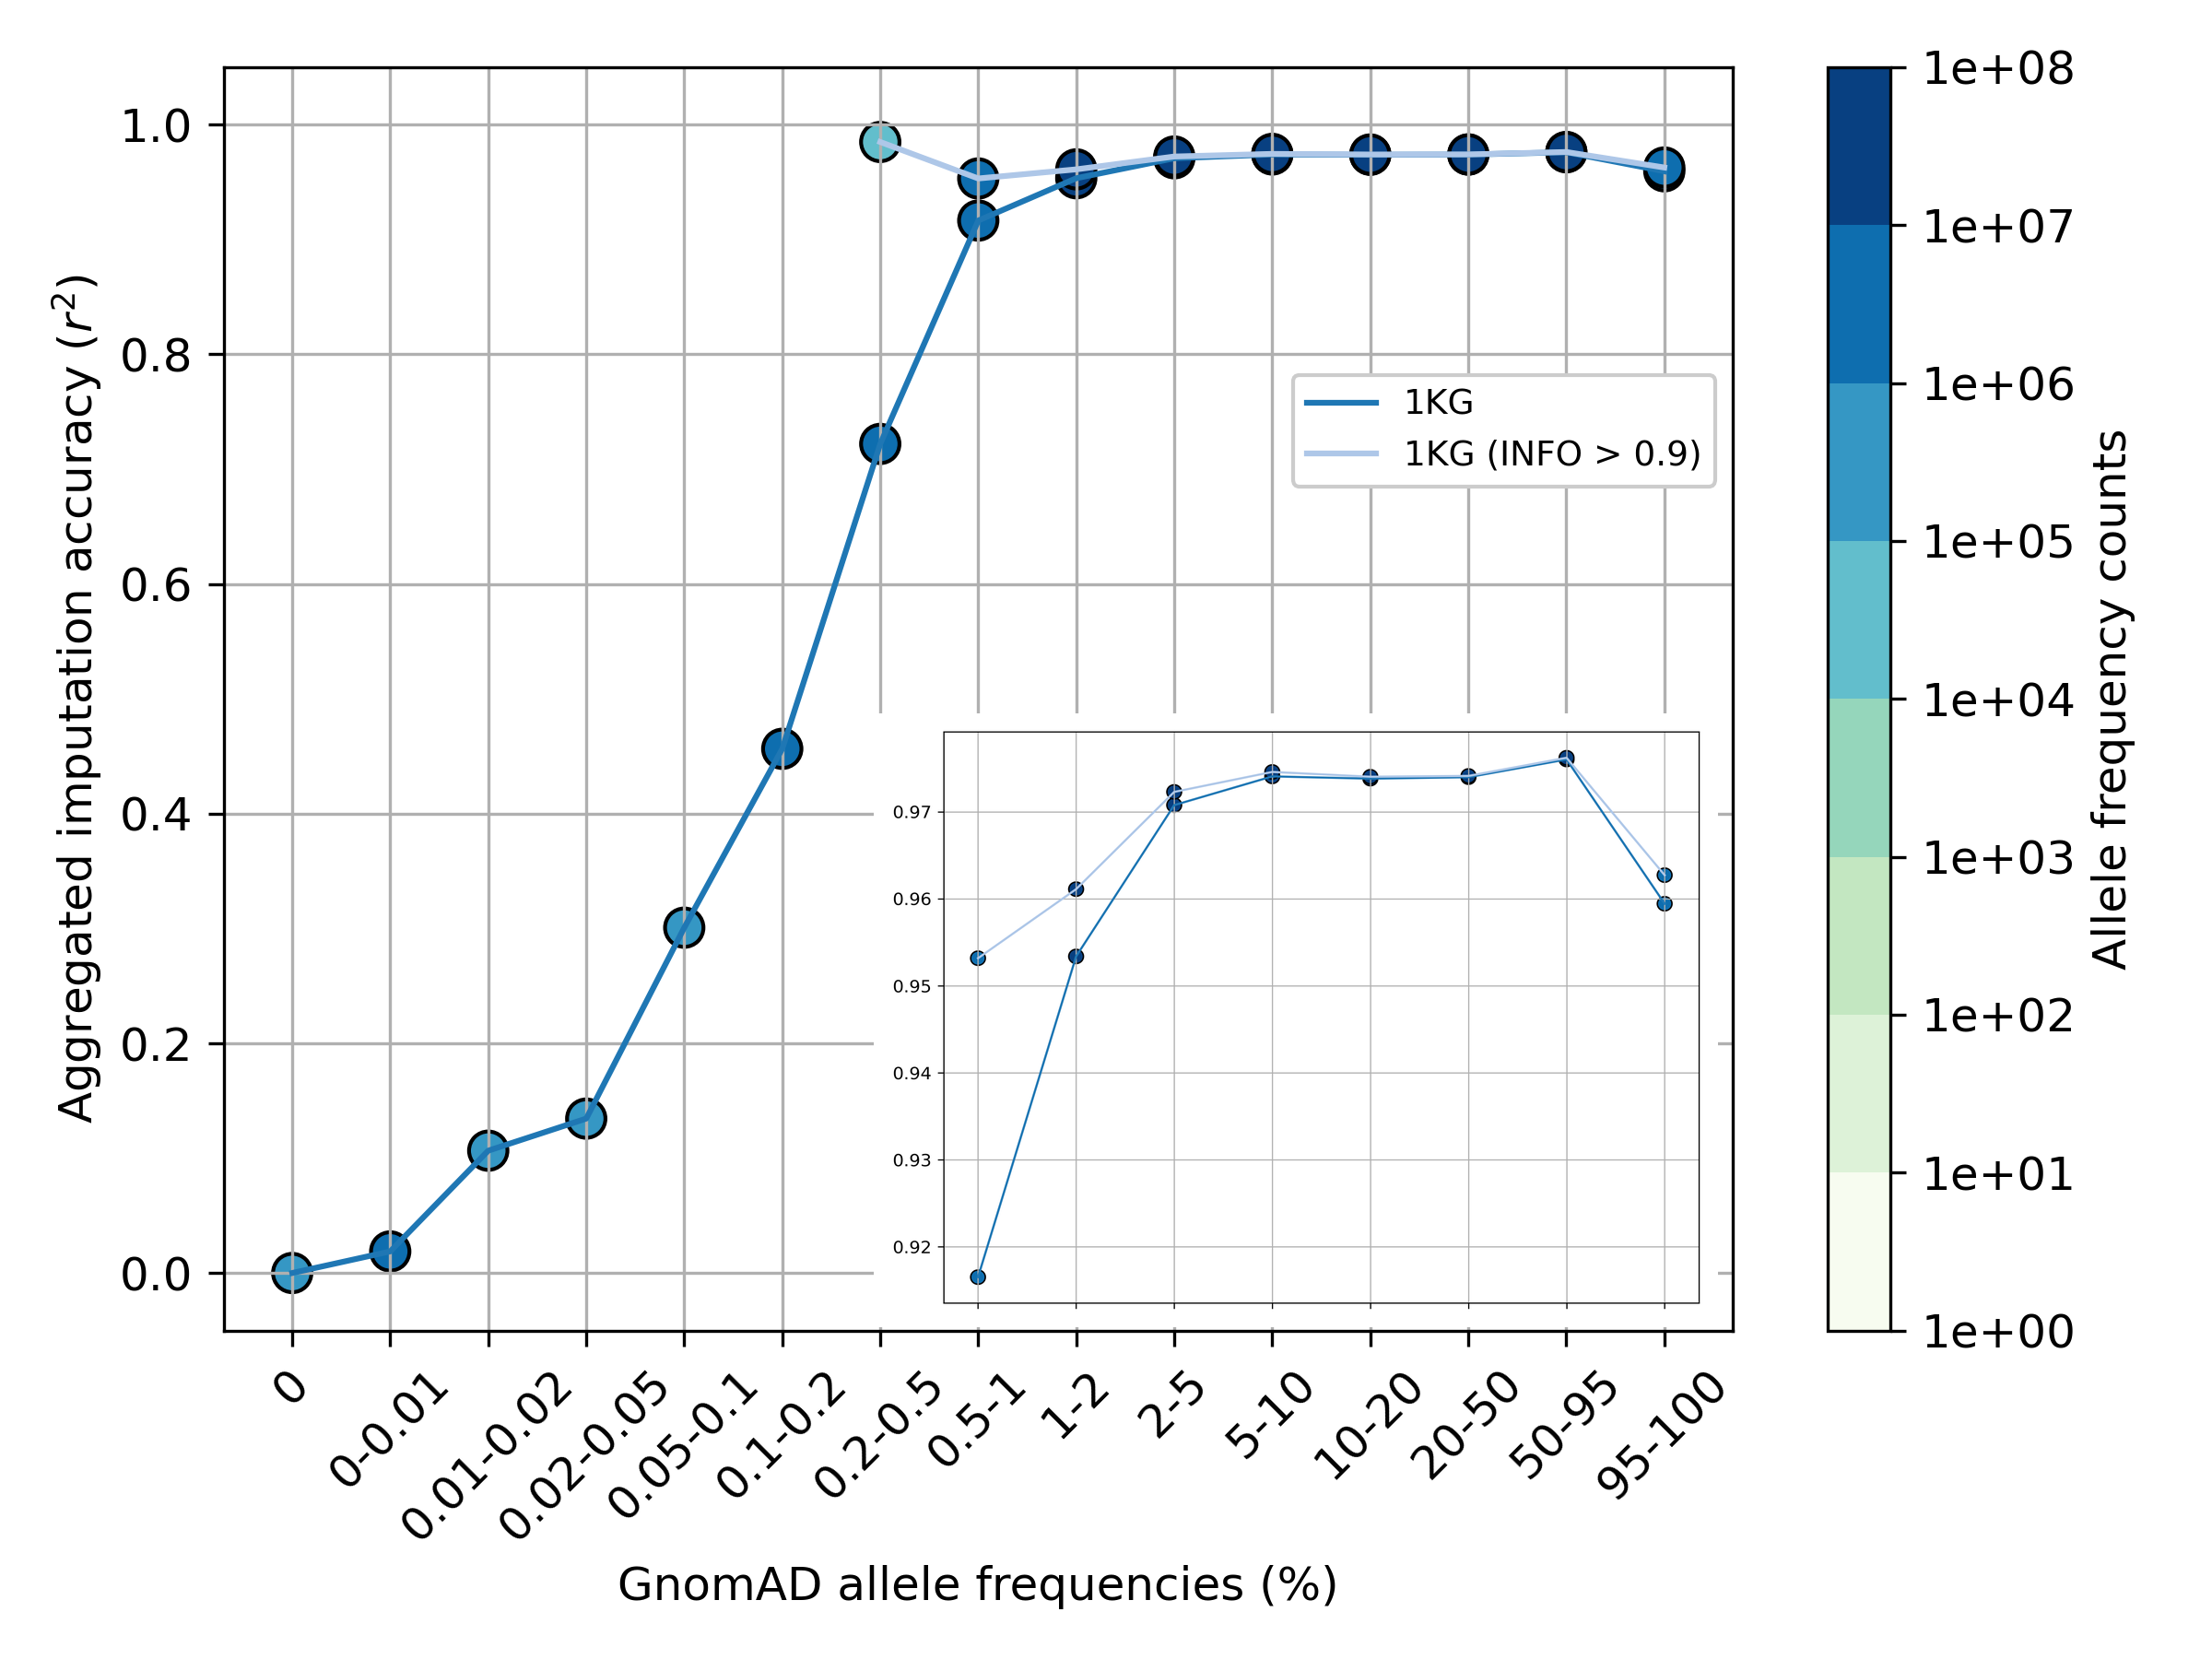

In [46]:
impacc_lst = impaccs[:2]
t = 0.01
metric = 'r2'
line_colors = CATEGORY_CMAP_HEX
labels = ['1KG', '1KG (INFO > 0.9)']
cols = ['AF', metric, metric + '_AC']
df_lst = [impacc[cols] for impacc in impacc_lst]

for triplet in df_lst:
    c0, c1, c2 = tuple(list(triplet.columns))
    triplet[c1] = triplet[c1].replace(-9, 0)

fig1 = plt.figure(figsize=(8, 6), dpi = 300)
ax = fig1.add_subplot(111)
plt.grid(False)

magnitude = 8
bounds = np.logspace(0, 8, magnitude + 1)
norm = mcolors.BoundaryNorm(bounds, COLORBAR_CMAP.N)
fmt = lambda x, pos: '{:.0e}'.format(x)

for i in range(len(df_lst)):
    triplet = df_lst[i]
    c0, c1, c2 = tuple(list(triplet.columns))

    label = c1 if labels is None else labels[i]

    x = np.arange(triplet.shape[0])
    afs = lcwgsus.generate_af_axis(triplet[c0].values)
    vals = triplet[c1]
    allele_counts = triplet[c2]
    
    if i != 0:
        triplet = triplet[triplet[metric] != 0]
        x = triplet.index.tolist()
        vals = triplet[c1]
        allele_counts = triplet[c2]

    plt.plot(x, vals, label=label, c=line_colors[i])

    plt.ylim((-0.05, 1.05))
    if i == 0:
        plt.xticks(x, afs, rotation=45)

    im = ax.scatter(x,
                    vals,
                    c=allele_counts,
                    edgecolor='black',
                    cmap=COLORBAR_CMAP,
                    norm=norm,
                    s=100)

plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            format=FuncFormatter(fmt),
            label='Allele frequency counts')

plt.xlabel('GnomAD allele frequencies (%)')
plt.title(title)
ax.legend(
    loc = 'upper right',
    bbox_to_anchor=(1, 0.77),
    framealpha=1,
    prop={'size': 9}
)
plt.ylabel('Aggregated imputation accuracy ($r^2$)')

ax.grid()
fig1.tight_layout()
fig2 = lcwgsus.plot_imputation_accuracy_typed(df_lst, labels = labels, threshold = t, set_ylim = False, subplot = True)
f1 = lcwgsus.combine_imputation_accuracy_plots(fig1, fig2, 
                                       threshold = t, 
                                       save_fig = save_fig, 
                                       outdir = outdir, 
                                       save_name = 'f1.png')
f1

# F2 lc-mGen increases imputation accuracy

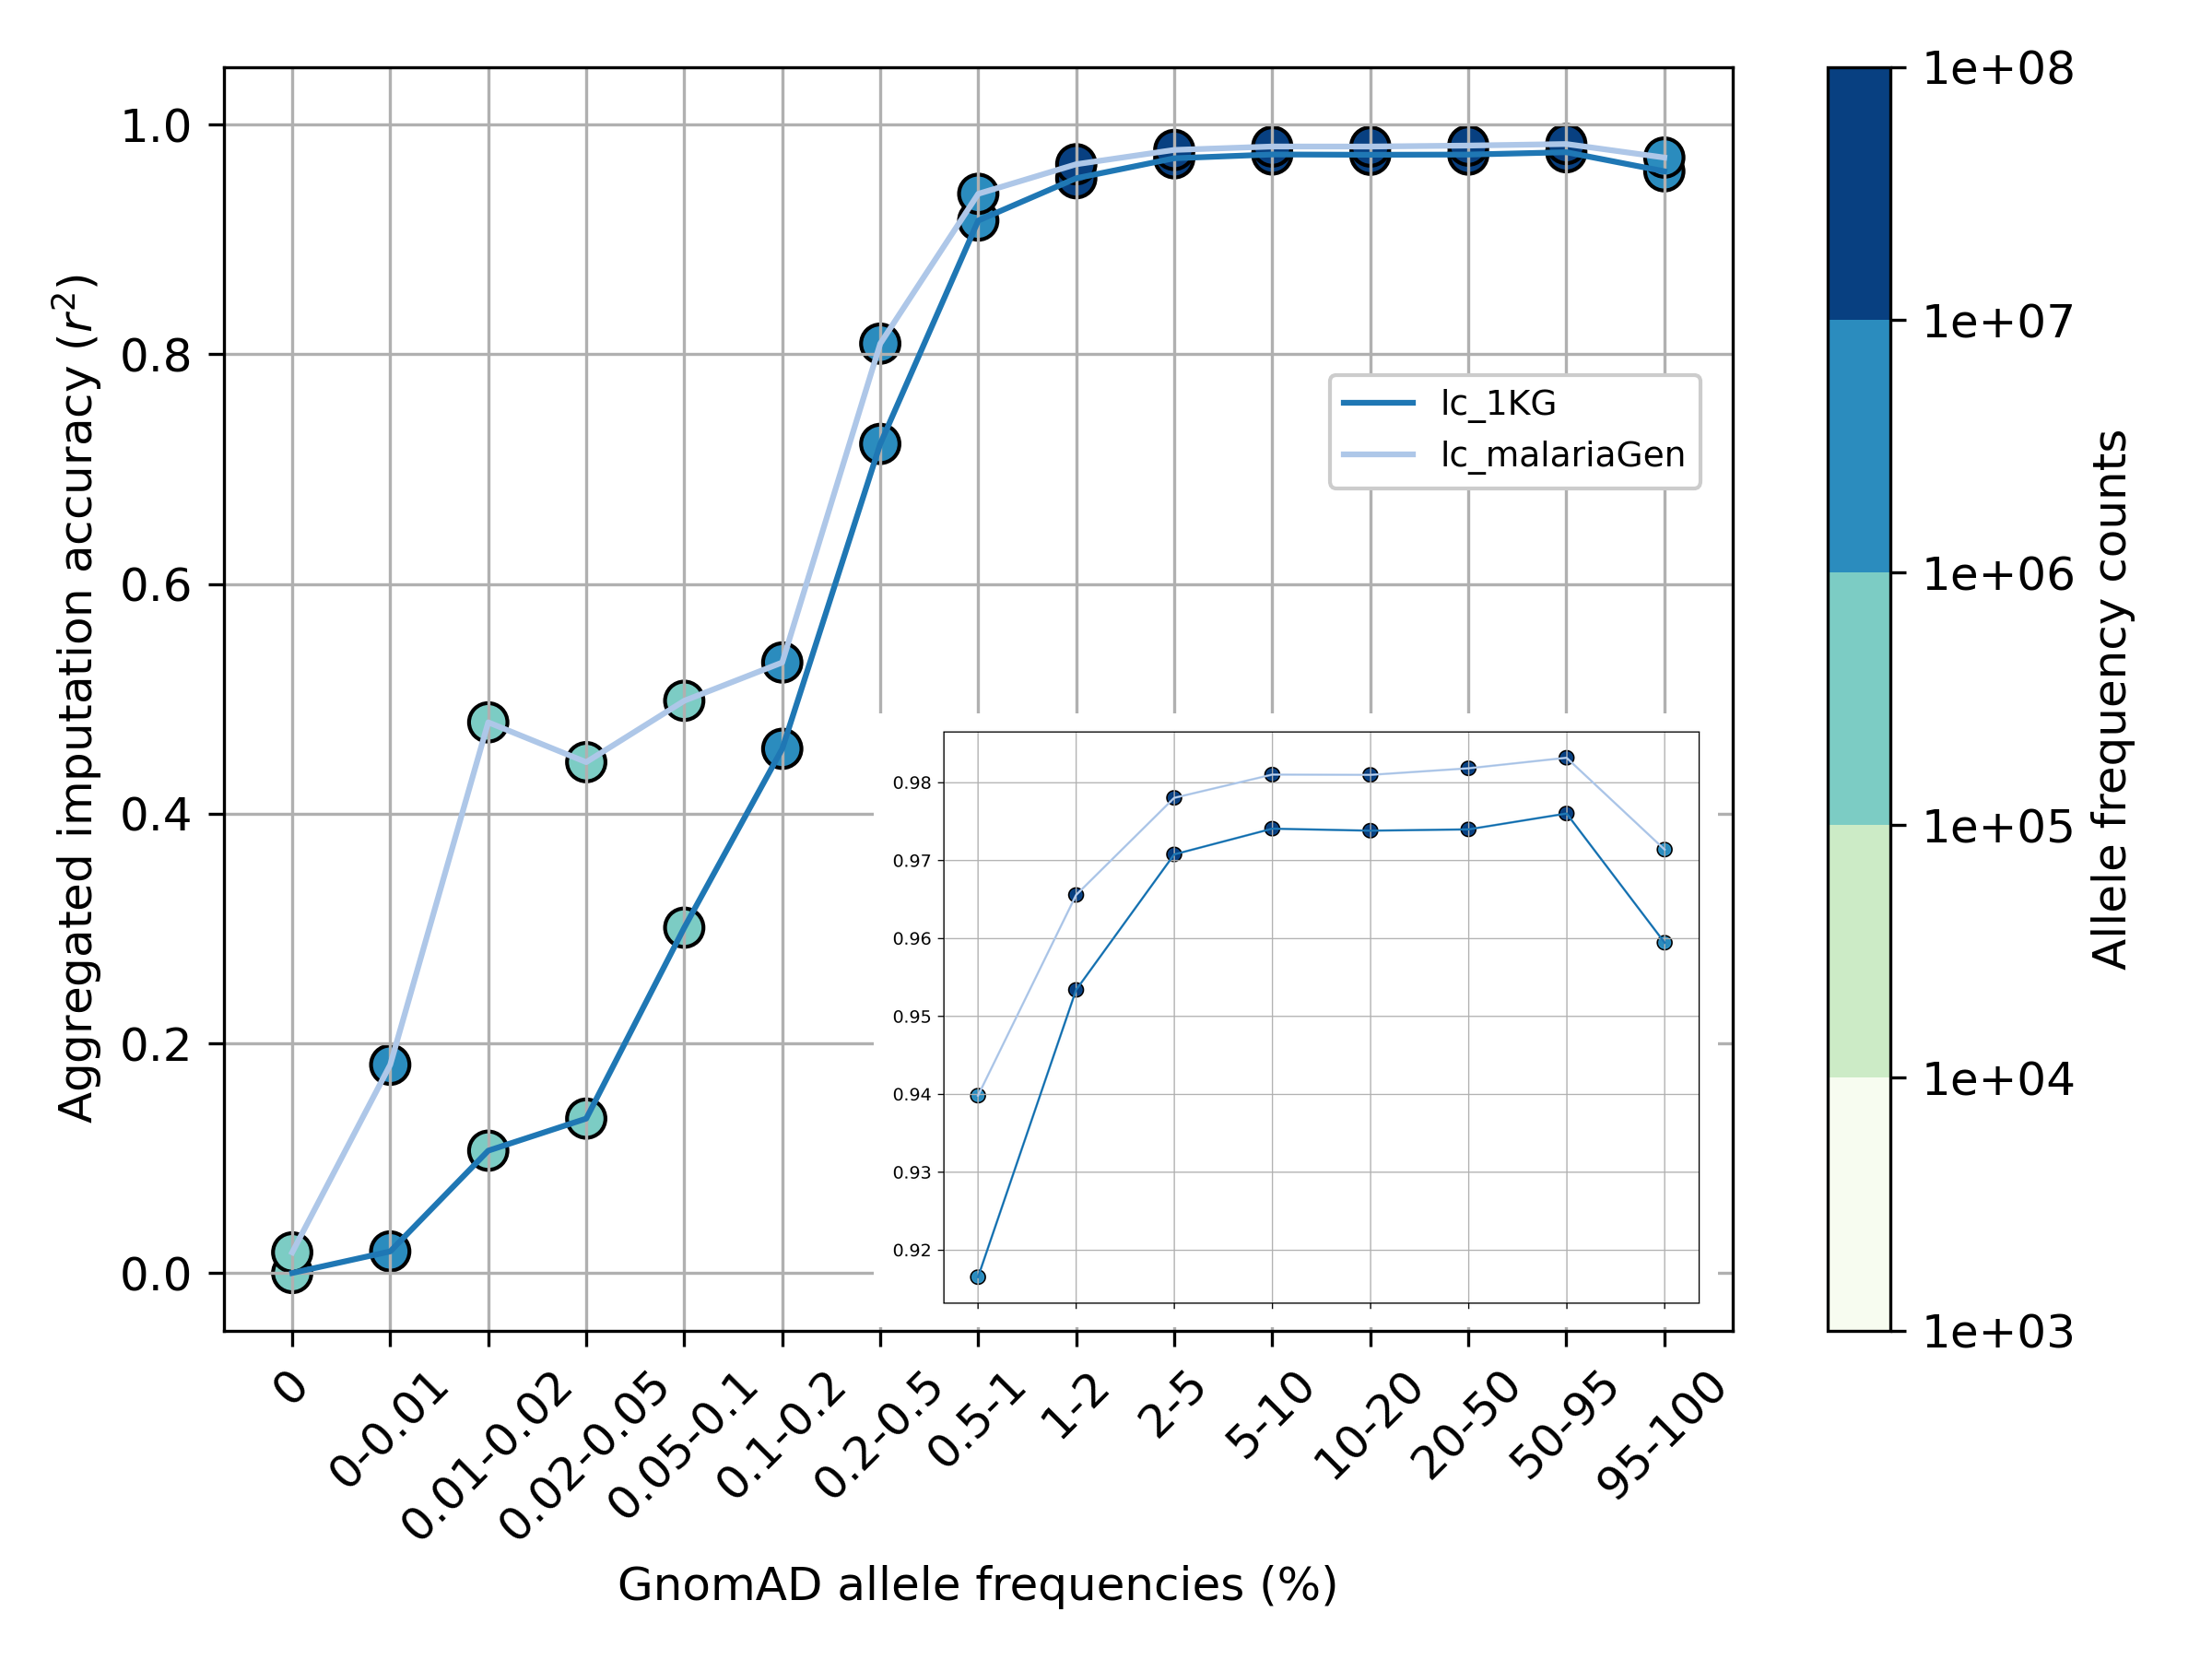

In [55]:
impaccs = []
for d in imp_dirs:
    v = pd.read_csv(d + "impacc/all_samples/by_sample/all.v.impacc.tsv", sep = '\t')
    impaccs.append(v)

ix = [0, 12]
labels = ['lc_1KG', 'lc_malariaGen']
title = ''
t = 0.01
save_prefix = 'f2'

f2 = lcwgsus.plot_imputation_accuracy_sequential(ix, impaccs, labels, title, t,
                                         save_fig = save_fig, outdir = outdir, save_prefix = save_prefix)
f2[-1]

# F3 Two-stage imputation

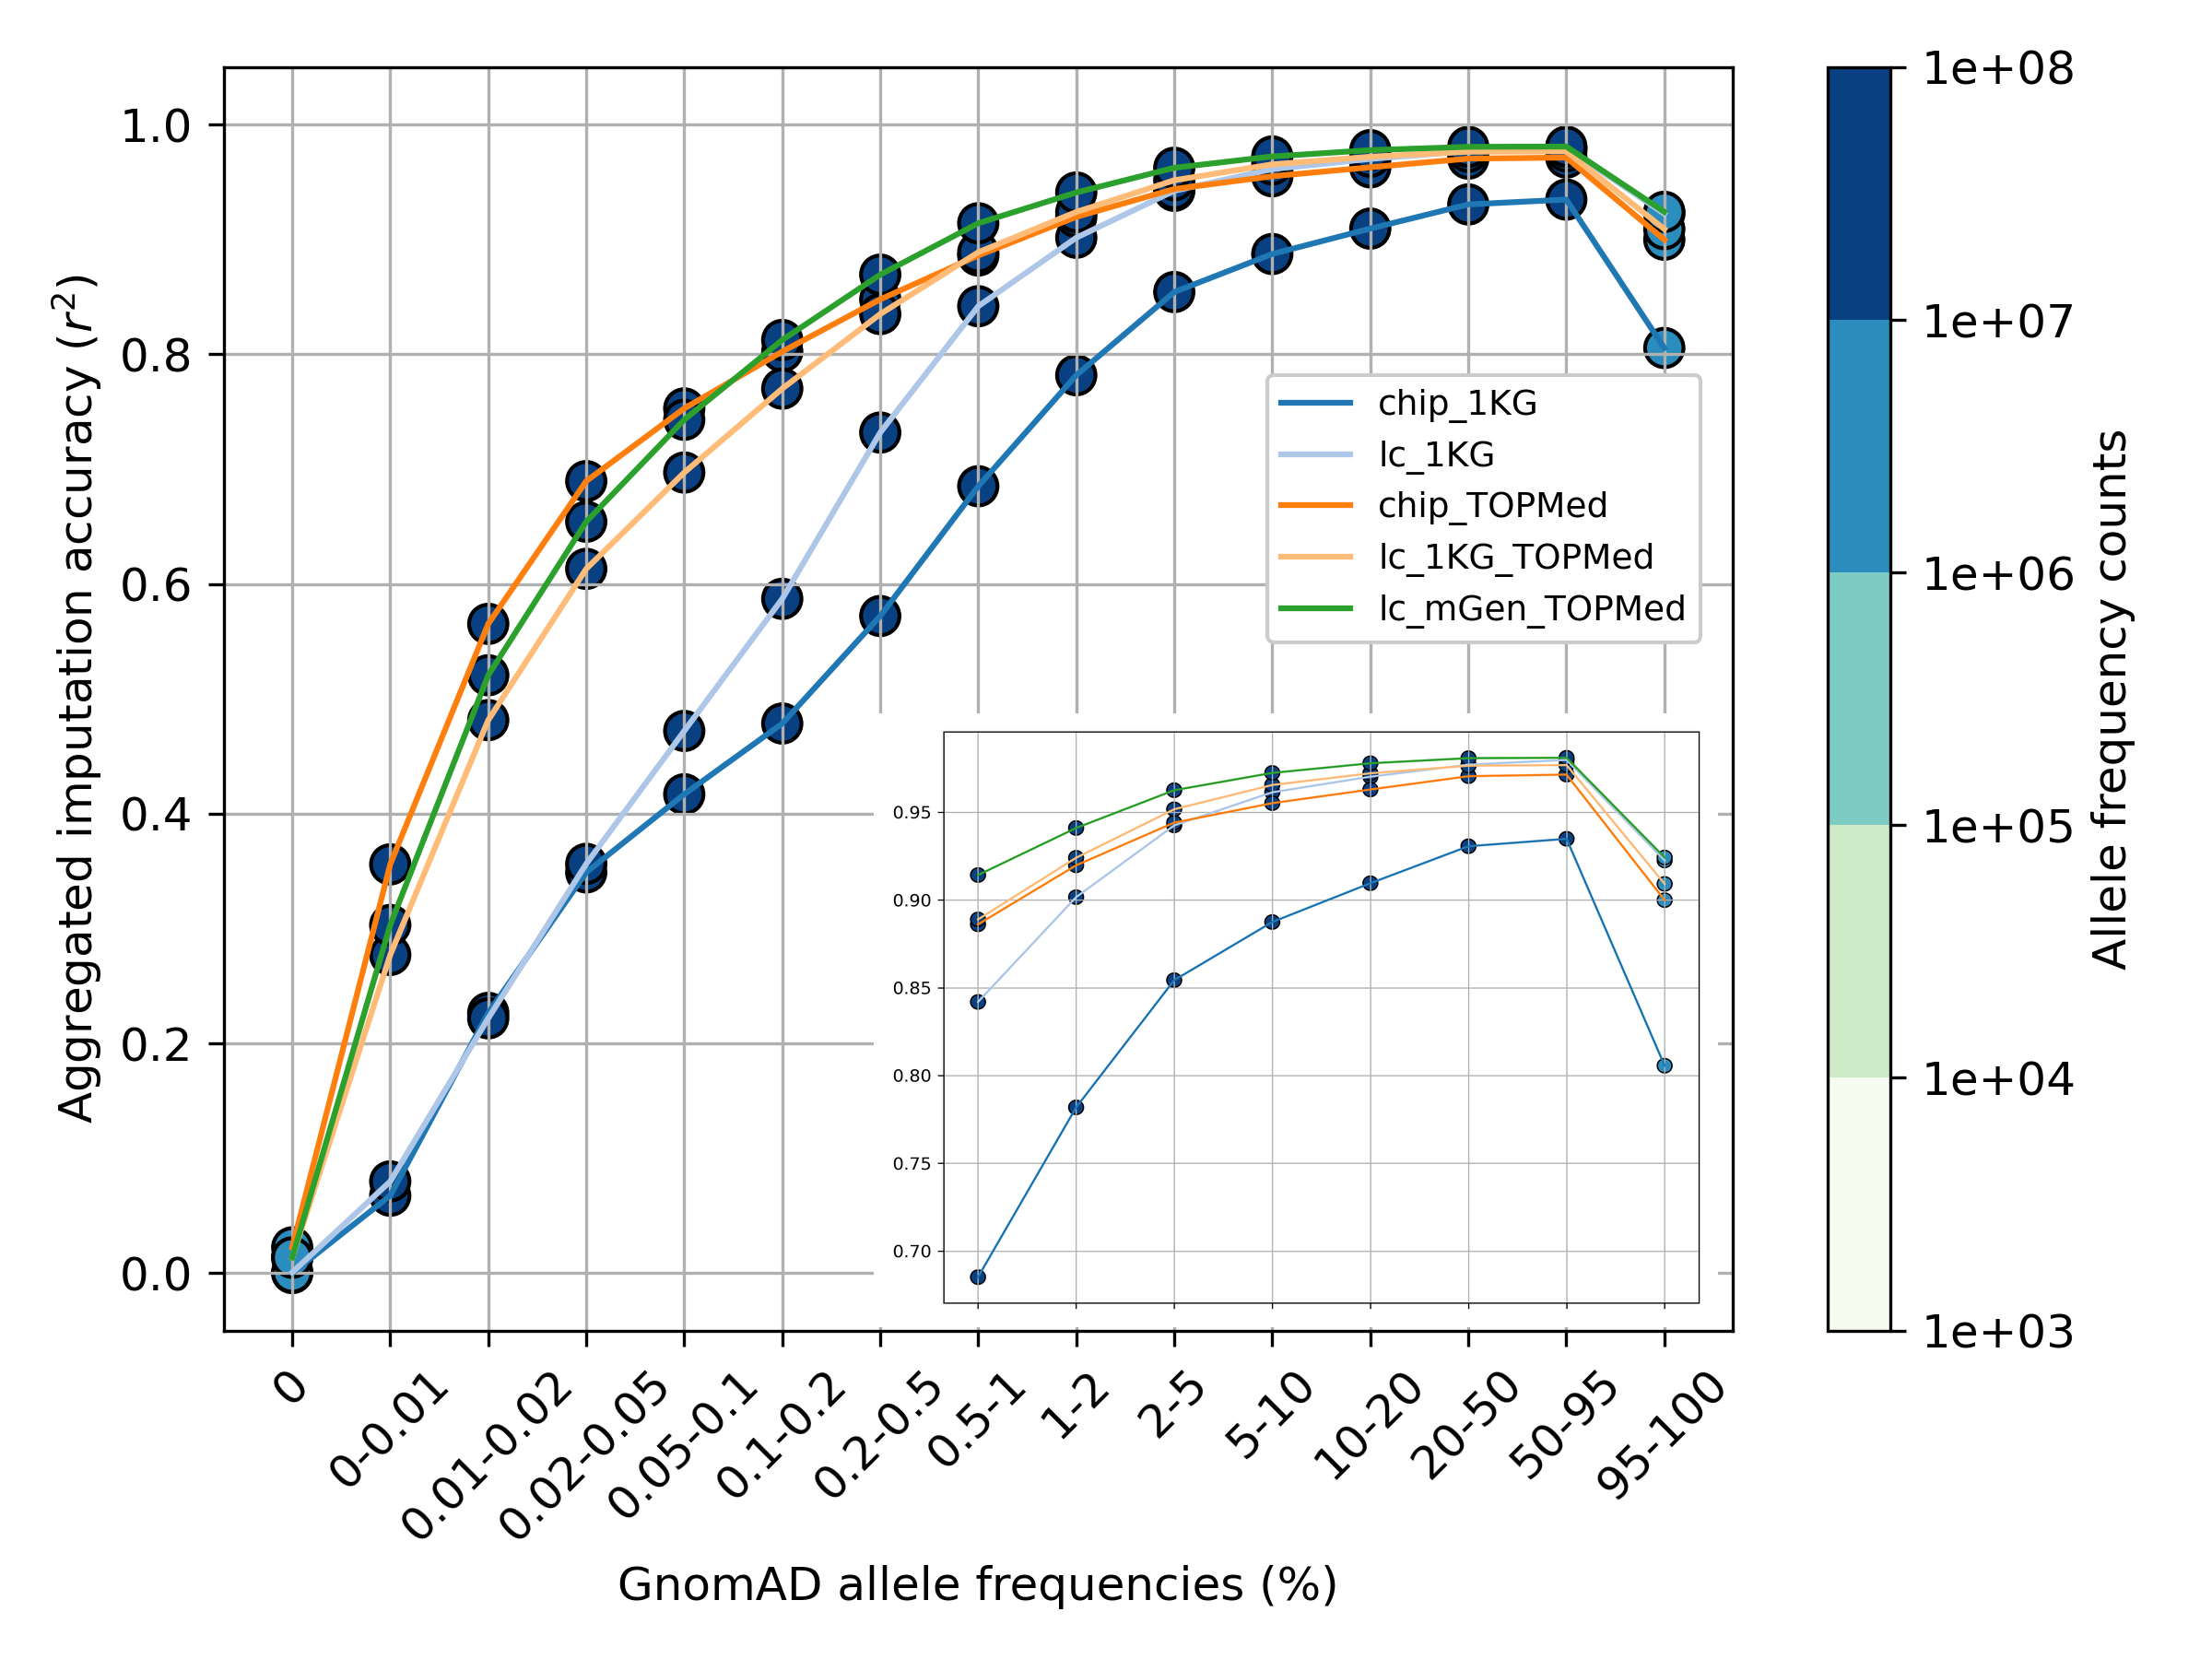

In [75]:
impaccs = []
for d in imp_dirs:
    v = pd.read_csv(d + "/impacc/all_samples/by_sample/all.v.impacc.tsv", sep = '\t')
    impaccs.append(v)

ix = [2, 3, 4, 6, 10]
labels = ['chip_1KG', 'lc_1KG', 'chip_TOPMed', 'lc_1KG_TOPMed', 'lc_mGen_TOPMed']
title = ''
t = 0.01
save_fig = True
save_prefix = 'f3'
res = lcwgsus.plot_imputation_accuracy_sequential(ix, impaccs, labels, title, t,func = lcwgsus.plot_imputation_accuracy_gw,
                                         save_fig = save_fig, outdir = outdir, save_prefix = save_prefix)
res[-1]

# F4 HLA imputation accuracy

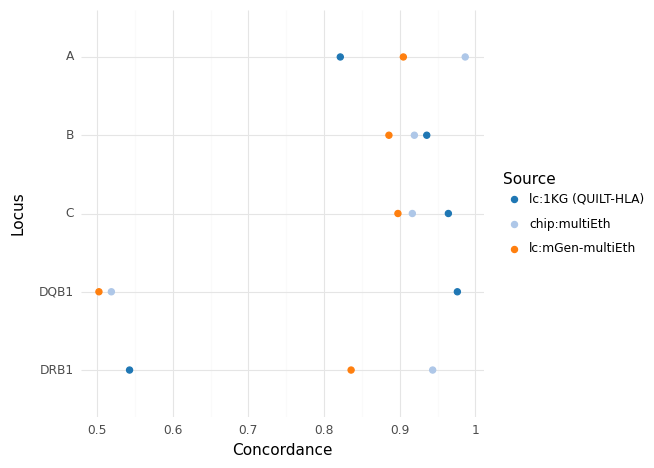

<Figure Size: (640 x 480)>

In [77]:
hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv')

def plot_hla_imputation_accuracy(hla_dirs, labels, indices = None, cmap = CATEGORY_CMAP_STR, recode_two_field = False, save_fig=False, outdir=None, save_name=None):
    hla_reports = []
    
    colors = plt.get_cmap(cmap).colors[:(len(labels))]
    hex_codes = [mcolors.to_hex(color) for color in colors]
    colors = dict(zip(labels, hex_codes))
    
    if indices is not None:
        hla_dirs = [hla_dirs[i] for i in indices]
        labels = [labels[i] for i in indices]
        
    for d, l in zip(hla_dirs, labels):
        report = lcwgsus.calculate_hla_imputation_accuracy(d, hla, l, recode_two_field = recode_two_field)
        hla_reports.append(report)
    report = pd.concat(hla_reports)
    report['Locus'] = pd.Categorical(report['Locus'], categories=HLA_GENES[::-1], ordered=True)
    report['Source'] = pd.Categorical(report['Source'], categories=labels, ordered=True)
    report = report.sort_values(by = 'Locus')
        
    twofield = report[report['Resolution'] == 'Two field']
    p2 = (
        ggplot(twofield, aes(x='Concordance', y='Locus', color='Source')) +
        geom_point(size=2) +
        scale_color_manual(values=colors) +
#         labs(x='Concordance', y='Locus', color='Source') + 
        theme_minimal() + 
        theme(axis_text_y=element_text(angle=0), title=element_text(hjust=2))
    )
    return p2

hla_dirs = ['/well/band/users/rbx225/GAMCC/results/hla/imputation/batches_archived/', 
                  '/well/band/users/rbx225/GAMCC/results/hla/server/chip_vanilla/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_mGen0.9/chr6.dose.vcf.gz']
labels =  ['lc:1KG (QUILT-HLA)', 'chip:multiEth', 'lc:mGen-multiEth']

p = plot_hla_imputation_accuracy(hla_dirs, labels)
p.save(outdir + "f4.png")
p

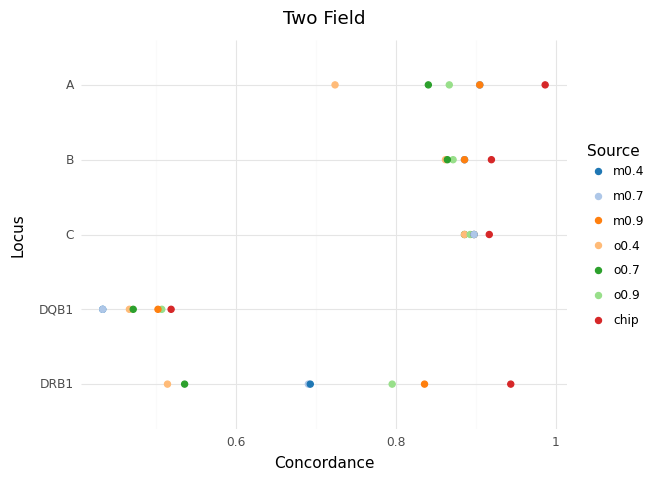

<Figure Size: (640 x 480)>

In [76]:
hla_dirs = ['/well/band/users/rbx225/GAMCC/results/hla/server/lc_mGen0.4/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_mGen0.7/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_mGen0.9/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_oneKG0.4/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_oneKG0.7/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_oneKG0.9/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/chip_vanilla/chr6.dose.vcf.gz']
labels =  ['m0.4', 'm0.7', 'm0.9', 'o0.4', 'o0.7', 'o0.9', 'chip']

p = plot_hla_imputation_accuracy(hla_dirs, labels, recode_two_field = False)
p

# F5 West African HLA reference panel

In [ ]:
# TBD

# F6 Low-coverage imputation on biologically important regions

In [ ]:
# TBD

# SF1 lcWGS sample performance

## SF1a Scatterplot

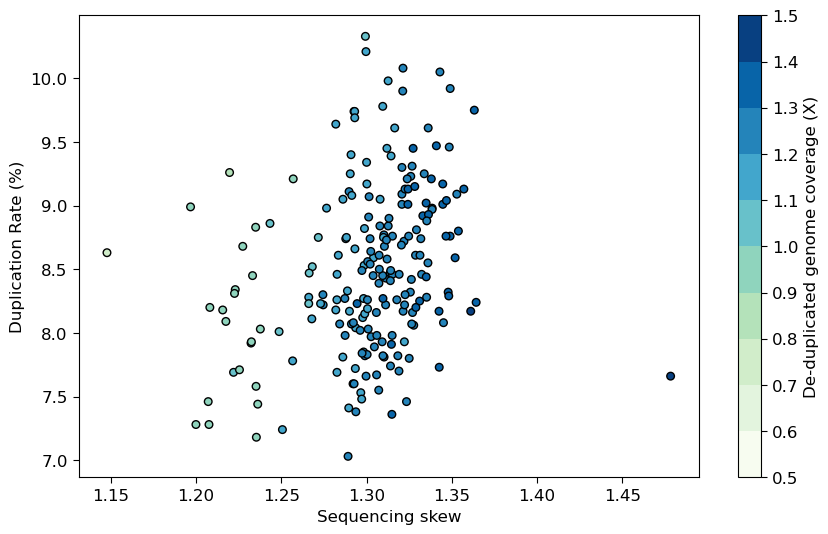

In [6]:
metrics = pd.read_csv('results/metrics.csv')
expectation_ary = []
for mu in metrics['Coverage']:
    poisson_expectation = np.cumsum(
            poisson.pmf(np.arange(10), mu=mu, loc=0))
    expectation_ary.append(poisson_expectation[0])
metrics['Sequencing skew'] = metrics['Uncoverage']/expectation_ary

fv = metrics[~metrics['Sample_Name'].str.contains('mini')]

title = 'lcWGS sample performance'

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)
plt.grid(False)

cmap = plt.get_cmap('GnBu')
magnitude = 10
bounds = np.linspace(0.5, 1.5, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = plt.scatter(fv['Sequencing skew'], 
                 fv['Dup_Rate'] * 100, c = fv['Coverage'], edgecolor='black', cmap=cmap, 
                 norm=norm, s = 30, marker = 'o', label = 'Full Volume')
plt.colorbar(im, boundaries=bounds, ticks = bounds, label='De-duplicated genome coverage (X)')

plt.xlabel('Sequencing skew')
plt.ylabel('Duplication Rate (%)')
plt.savefig(f'{outdir}sf1a.png', dpi = 300)

## SF1b Histogram

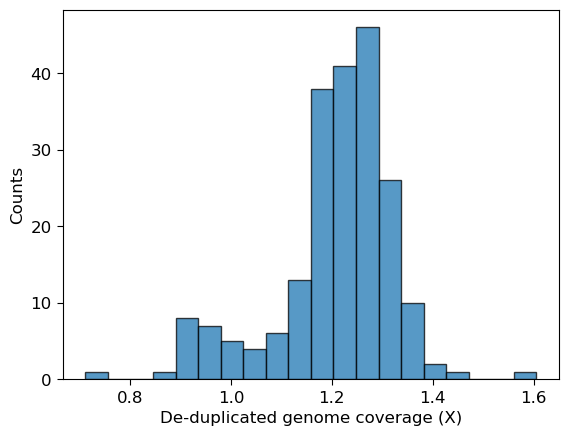

In [7]:
metrics = pd.read_csv('results/metrics.csv')
fv = metrics[~metrics['Sample_Name'].str.contains('mini')]
plt.hist(fv['Coverage'], bins = 20, ec = 'black', alpha = 0.75)
plt.xlabel('De-duplicated genome coverage (X)')
plt.ylabel('Counts')
plt.savefig(f'{outdir}sf1b.png', dpi = 300)

# SF2 Chip QC

In [8]:
db = sqlite3.connect( "results/chip/qc/chip.qc.sqlite" )
snp = pd.read_sql_query( "SELECT * FROM autosomesView", db )
sample = pd.read_sql_query( "SELECT * FROM sample_statsView", db )
ethnic = pd.read_csv('data/metadata/ethnic_group.csv')
ethnic = ethnic.rename(columns = {'Chip_Name': 'sample_id'})
PC = pd.read_sql_query( "SELECT * FROM PCsView", db )
PC = PC[PC['analysis']=='PCs:thin_1bp:exclude-duplicates']
PC = PC.merge(ethnic, on = 'sample_id', how = 'left')

df = lcwgsus.read_vcf('results/chip/vcf/chip_genotype.vcf.gz')

kinship = pd.read_csv( "results/chip/qc/PCs/chip_kinship_thin_1bp.exclude-duplicates.tsv.gz", comment = '#', sep = '\t')

snp = pd.merge(snp, df[['ID', 'ref', 'alt', 'pos']], left_on = 'rsid', right_on = 'ID')
snp = snp.drop(columns = ['alleleA', 'alleleB', 'position']).rename(columns = {'ref': 'alleleA', 'alt': 'alleleB', 'pos': 'position'})

snp_missing = 0.05
snp_hwe = 1e-6
sample_missing = 0.05
heterozygosity_nstd = 3

drop_history = {}
num = snp.shape[0]
drop_history['original'] = num

snp = snp[~snp['chromosome'].isin(['MT', 'NA'])]
drop_history['drop_non-autosome'] = num - snp.shape[0]
num = snp.shape[0]
snp = snp[snp['missing_proportion'] < 0.2]
drop_history['drop_snp_missing_0.2'] = num - snp.shape[0]
num = snp.shape[0]
snp = snp[snp['HW_exact_p_value'] > snp_hwe]
drop_history['drop_snp_hwe_1e-6'] = num - snp.shape[0]
num = snp.shape[0]
snp = snp[snp['missing_proportion'] < snp_missing]
drop_history['drop_snp_missing_0.05'] = num - snp.shape[0]
num = snp.shape[0]

chromosomes = [i for i in range(1,23)]
oneKGmafs = ["/well/band/users/rbx225/recyclable_files/AFs/oneKG_MAFs/oneKG_AF_AFR_chr" + str(i) + ".txt" for i in chromosomes]
oneKGaf = lcwgsus.multi_read_af(chromosomes, oneKGmafs)
oneKGaf = oneKGaf.rename(columns = {'MAF': 'prop'})
oneKGaf['prop'] = np.where(oneKGaf['prop'] > 0.5, 1 - oneKGaf['prop'], oneKGaf['prop'])

GGVPmafs = ["/well/band/users/rbx225/recyclable_files/AFs/ggvp_AFs/ggvp_AF_chr" + str(i) + ".txt" for i in chromosomes]
GGVPaf = lcwgsus.multi_read_af(chromosomes, GGVPmafs)
GGVPaf = GGVPaf.rename(columns = {'MAF': 'prop'})
GGVPaf['prop'] = np.where(GGVPaf['prop'] > 0.5, 1 - GGVPaf['prop'], GGVPaf['prop'])
af = pd.merge(oneKGaf, GGVPaf, on = ['chr', 'pos', 'ref', 'alt'], how = 'outer')
af['prop'] = af['prop_x'].combine_first(af['prop_y'])
af = af.drop(columns = ['prop_x', 'prop_y'])

chip_af = snp[['chromosome', 'position', 'alleleA', 'alleleB', 'minor_allele_frequency']]
chip_af = chip_af.rename(columns = {'chromosome': 'chr', 'position': 'pos', 'alleleA': 'ref', 'alleleB': 'alt', 'minor_allele_frequency': 'prop'})
chip_af = chip_af[chip_af['chr'].isin([str(i) for i in range(1,23)])]
chip_af['chr'] = chip_af['chr'].astype(int)
chip_af['ref'] = chip_af['ref'].astype(str)
chip_af['alt'] = chip_af['alt'].astype(str)

def fill_prop(r):
    if pd.isna(r['prop_y']):
        r['prop_y'] = r['prop_x']
    return r

final = pd.merge(chip_af, af, on = ['chr', 'pos', 'ref', 'alt'], how = 'left')
final = final.apply(fill_prop, axis = 1)

y = np.arange(1,51)/100

xp = y+0.2
xm = y-0.2

plt.figure(figsize=(10, 8))
plt.hexbin(final['prop_x']*100, final['prop_y']*100, gridsize = 50, bins = 'log', cmap = 'GnBu')
plt.xlabel('ChIP MAF (%)')
plt.ylabel('GGVP MAF (%)')
# plt.title('AFs BEFORE filtering')
plt.plot(xp*100, y*100, color = 'black')
plt.plot(xm*100, y*100, color = 'black')
plt.xlim([0, 50])
plt.ylim([0, 50])

plt.savefig(f'{outdir}sf2.png', dpi = 300)

KeyboardInterrupt: 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fed1dcb1970>>
Traceback (most recent call last):
  File "/well/band/users/rbx225/conda/skylake/envs/sus/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 785, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
  File "/well/band/users/rbx225/conda/skylake/envs/sus/lib/python3.8/threading.py", line 1344, in enumerate
    with _active_limbo_lock:
KeyboardInterrupt: 


# SF3 Gambian PCA

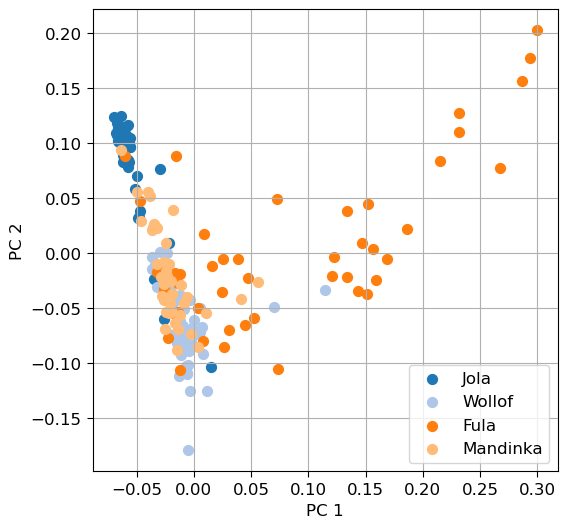

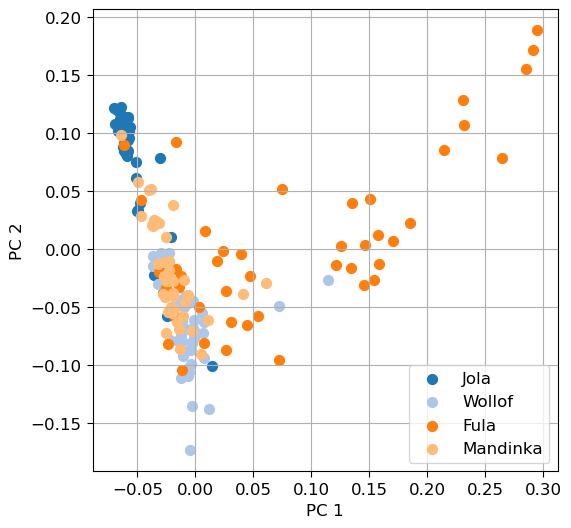

In [3]:
ethnic = pd.read_csv('data/metadata/ethnic_group.csv')
ethnic = ethnic.rename(columns = {'Chip_Name': 'FID'})
sl = pd.read_csv(SAMPLE_LINKER_FILE)
sl = sl[~sl['Sample_Name'].str.contains('mini')]
sl = {k:v for k,v in zip(sl['Sample_Name'], sl['Chip_Name'])}
PCchip = pd.read_csv('results/chip/qc/PCs/PCs.eigenvec', sep = ' ', header = None, names = ['FID', 'IID'] + ['PC' + str(i) for i in range(1,11)])
PCchip = PCchip.drop(columns = 'IID')
PClc = pd.read_csv('results/wip_vcfs/oneKG/vanilla/chip_sites/PCs.eigenvec', sep = ' ', header = None, names = ['FID', 'IID'] + ['PC' + str(i) for i in range(1,11)])
PClc = PClc[~PClc['IID'].str.contains('mini')]
PClc = PClc.drop(columns = 'IID')
def recode_names(r, sl = sl):
    r['FID'] = sl[r['FID']]
    return r
PClc = PClc.apply(recode_names, axis = 1)
PCchip = pd.merge(PCchip, ethnic, on = 'FID')
PClc = pd.merge(PClc, ethnic, on = 'FID').sort_values(by = 'FID')
PClc['PC2'] = -PClc['PC2']

lcwgsus.plot_pc(PClc, title = '', save_fig = save_fig, outdir = outdir, save_name = 'sf3a.png')
lcwgsus.plot_pc(PCchip, title = '', save_fig = save_fig, outdir = outdir, save_name = 'sf3b.png')

# SF4 Long-read and short-read simulations

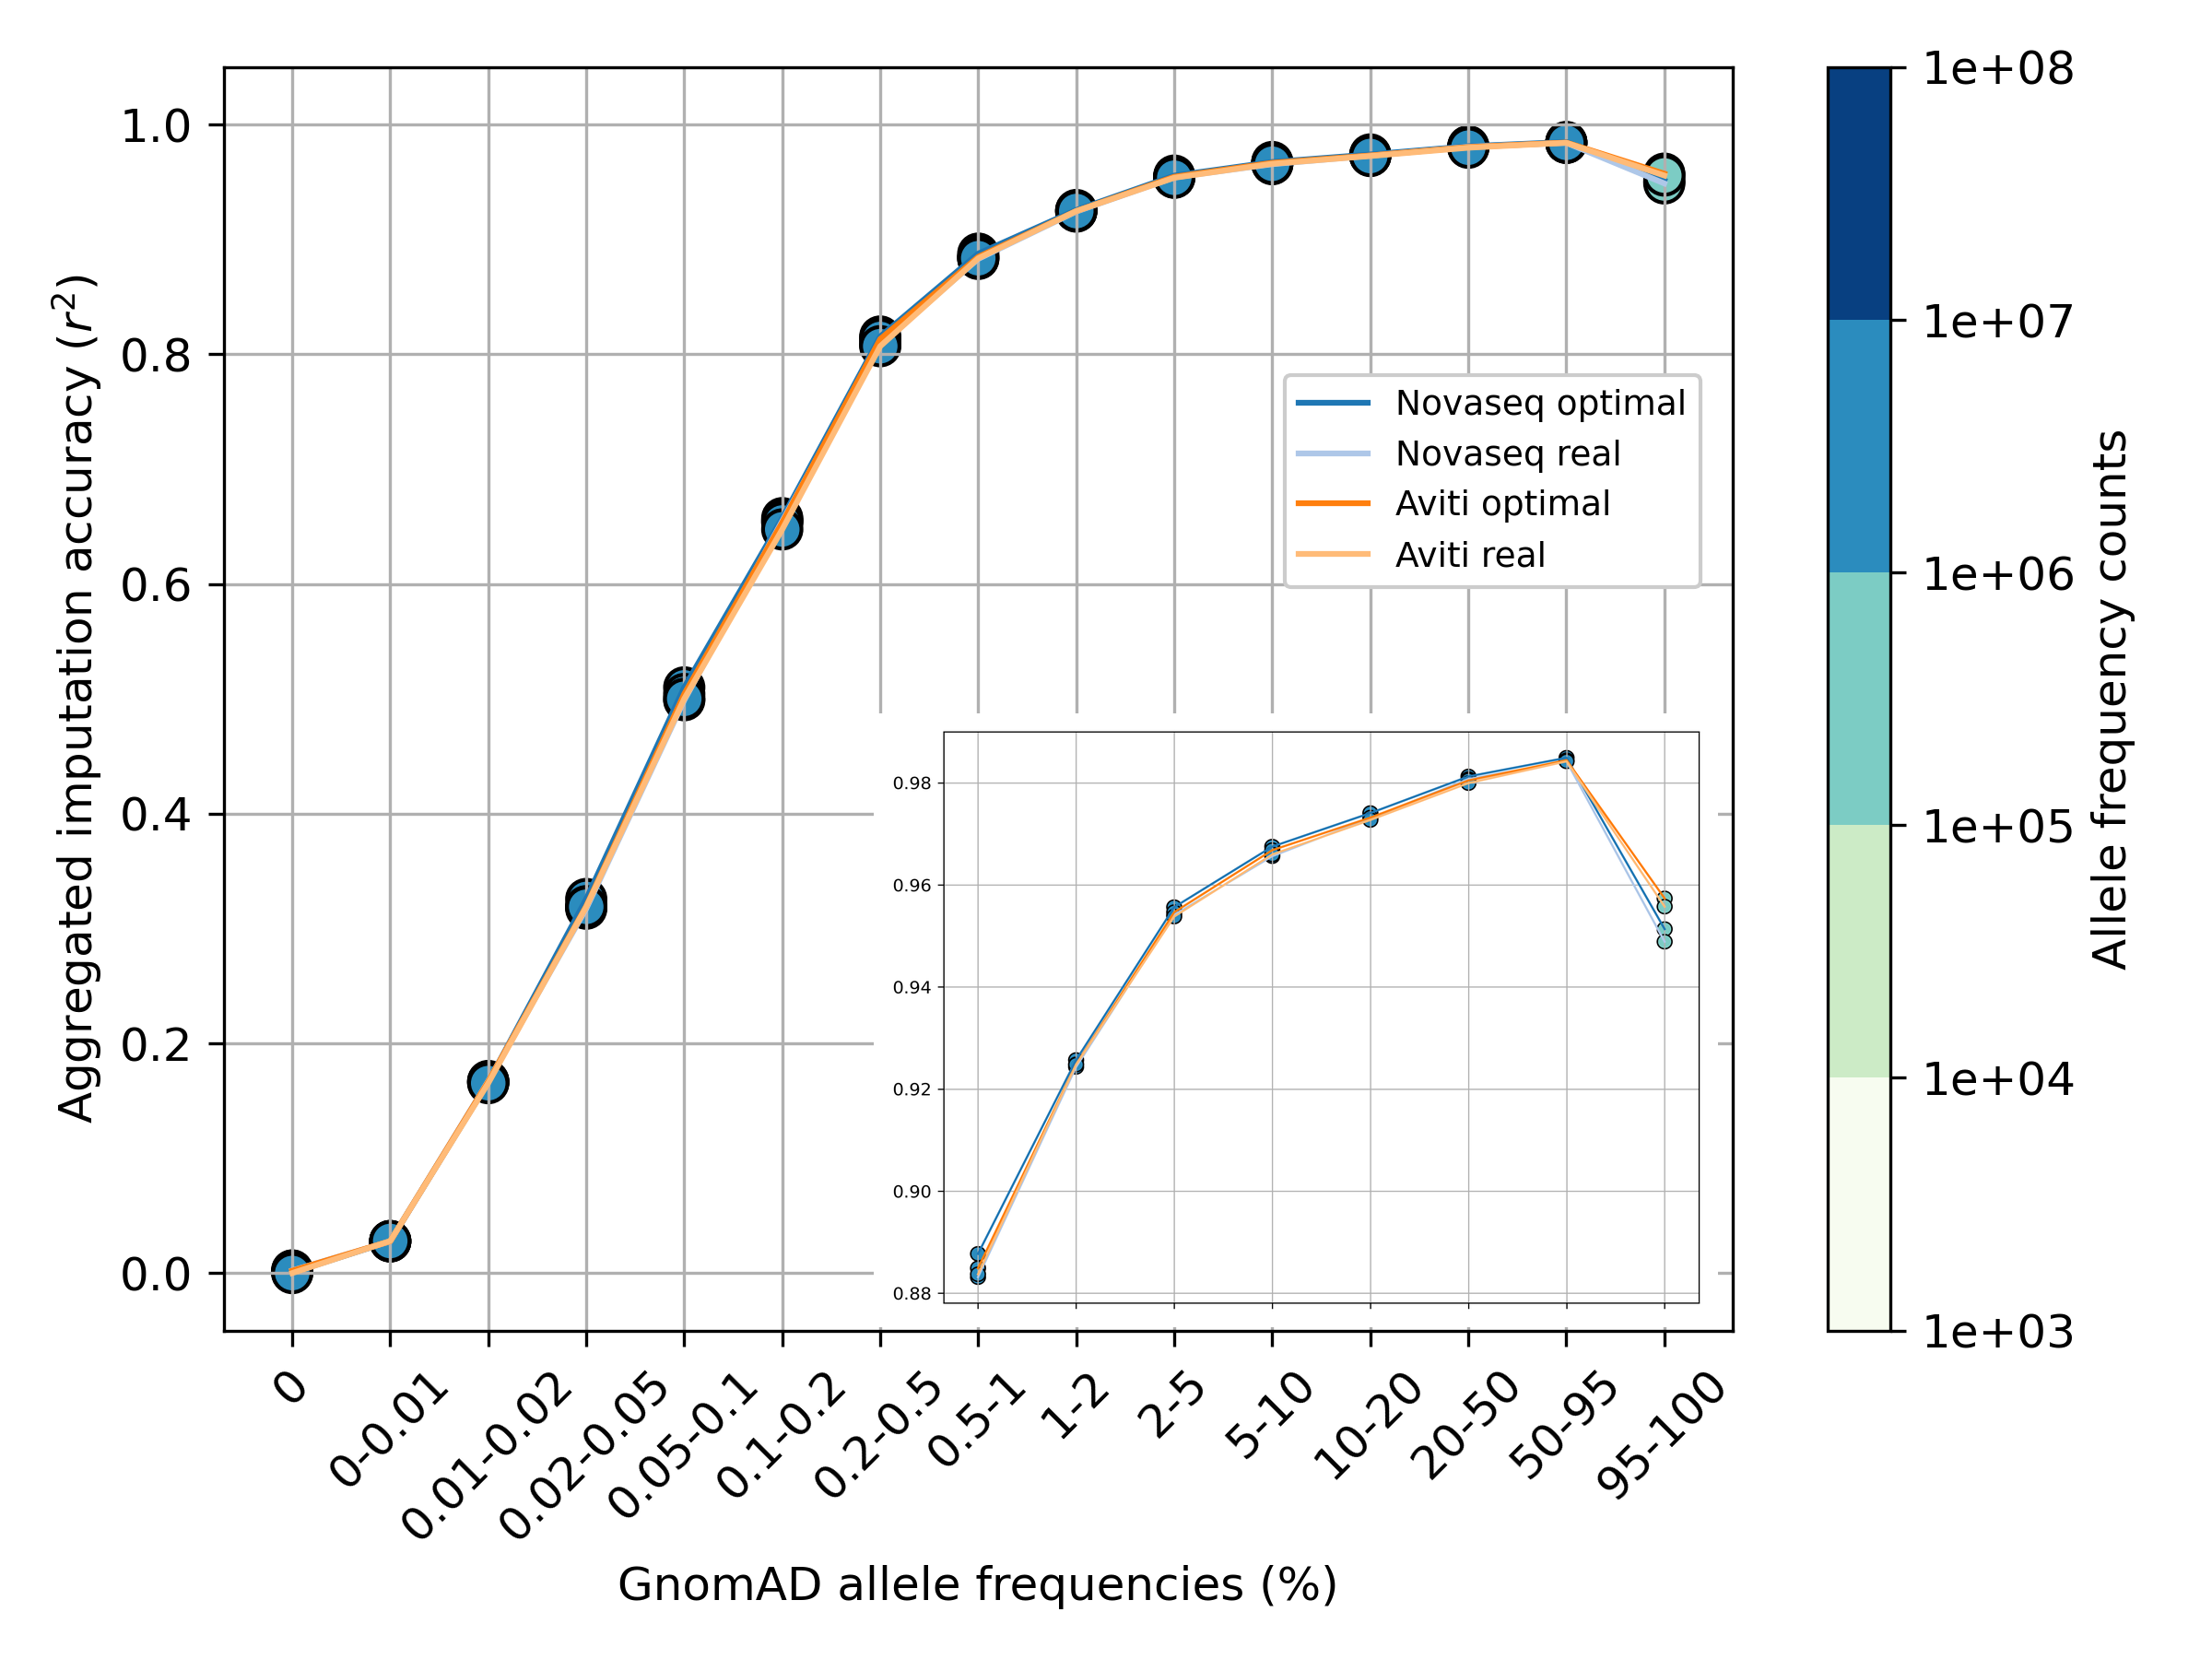

In [11]:
sr_rls = ["Novaseq long", "Novaseq optimal", "Novaseq real", "Novaseq short",
          "Aviti long", "Aviti optimal", "Aviti real", "Aviti short"]
sr_rls_old = ["151-long", "151-optimal", "151-real", "151-short", "300-long", "300-optimal", "300-real", "300-short"]

# sr_vanilla = pd.read_csv("/well/band/users/rbx225/archive/GAMCC_old/imputation_comparison/vanilla/lc_oneKG--hc--snps_gw/impacc/all_samples/by_sample/all.v.impacc.tsv", sep = '\t')
chrs = [pd.read_csv("/well/band/users/rbx225/GAMCC/results/imputation_comparison/sr_simulation/lc_oneKG--hc--snps_gw/impacc/all_samples/by_sample/chr" + i + ".v.tsv", sep = '\t') for i in CHROMOSOMES_ALL]

sr_ary = []
for r in sr_rls_old:
    sr_impaccs = []
    for df in chrs:
        sr_impaccs.append(df[df['sample'] == r].drop(columns = 'sample'))
    sr_ary.append(lcwgsus.average_impacc_by_chr(sr_impaccs))

ixs = [1,2,5,6]
labels = [sr_rls[i] for i in ixs]
dfs = sr_ary
title = ''
t = 0.01

save_fig = True
save_prefix = 'sf4a'
res = lcwgsus.plot_imputation_accuracy_sequential(ixs, dfs, labels, title, t,
                                         save_fig = save_fig, outdir = outdir, save_prefix = save_prefix)
res[-1]

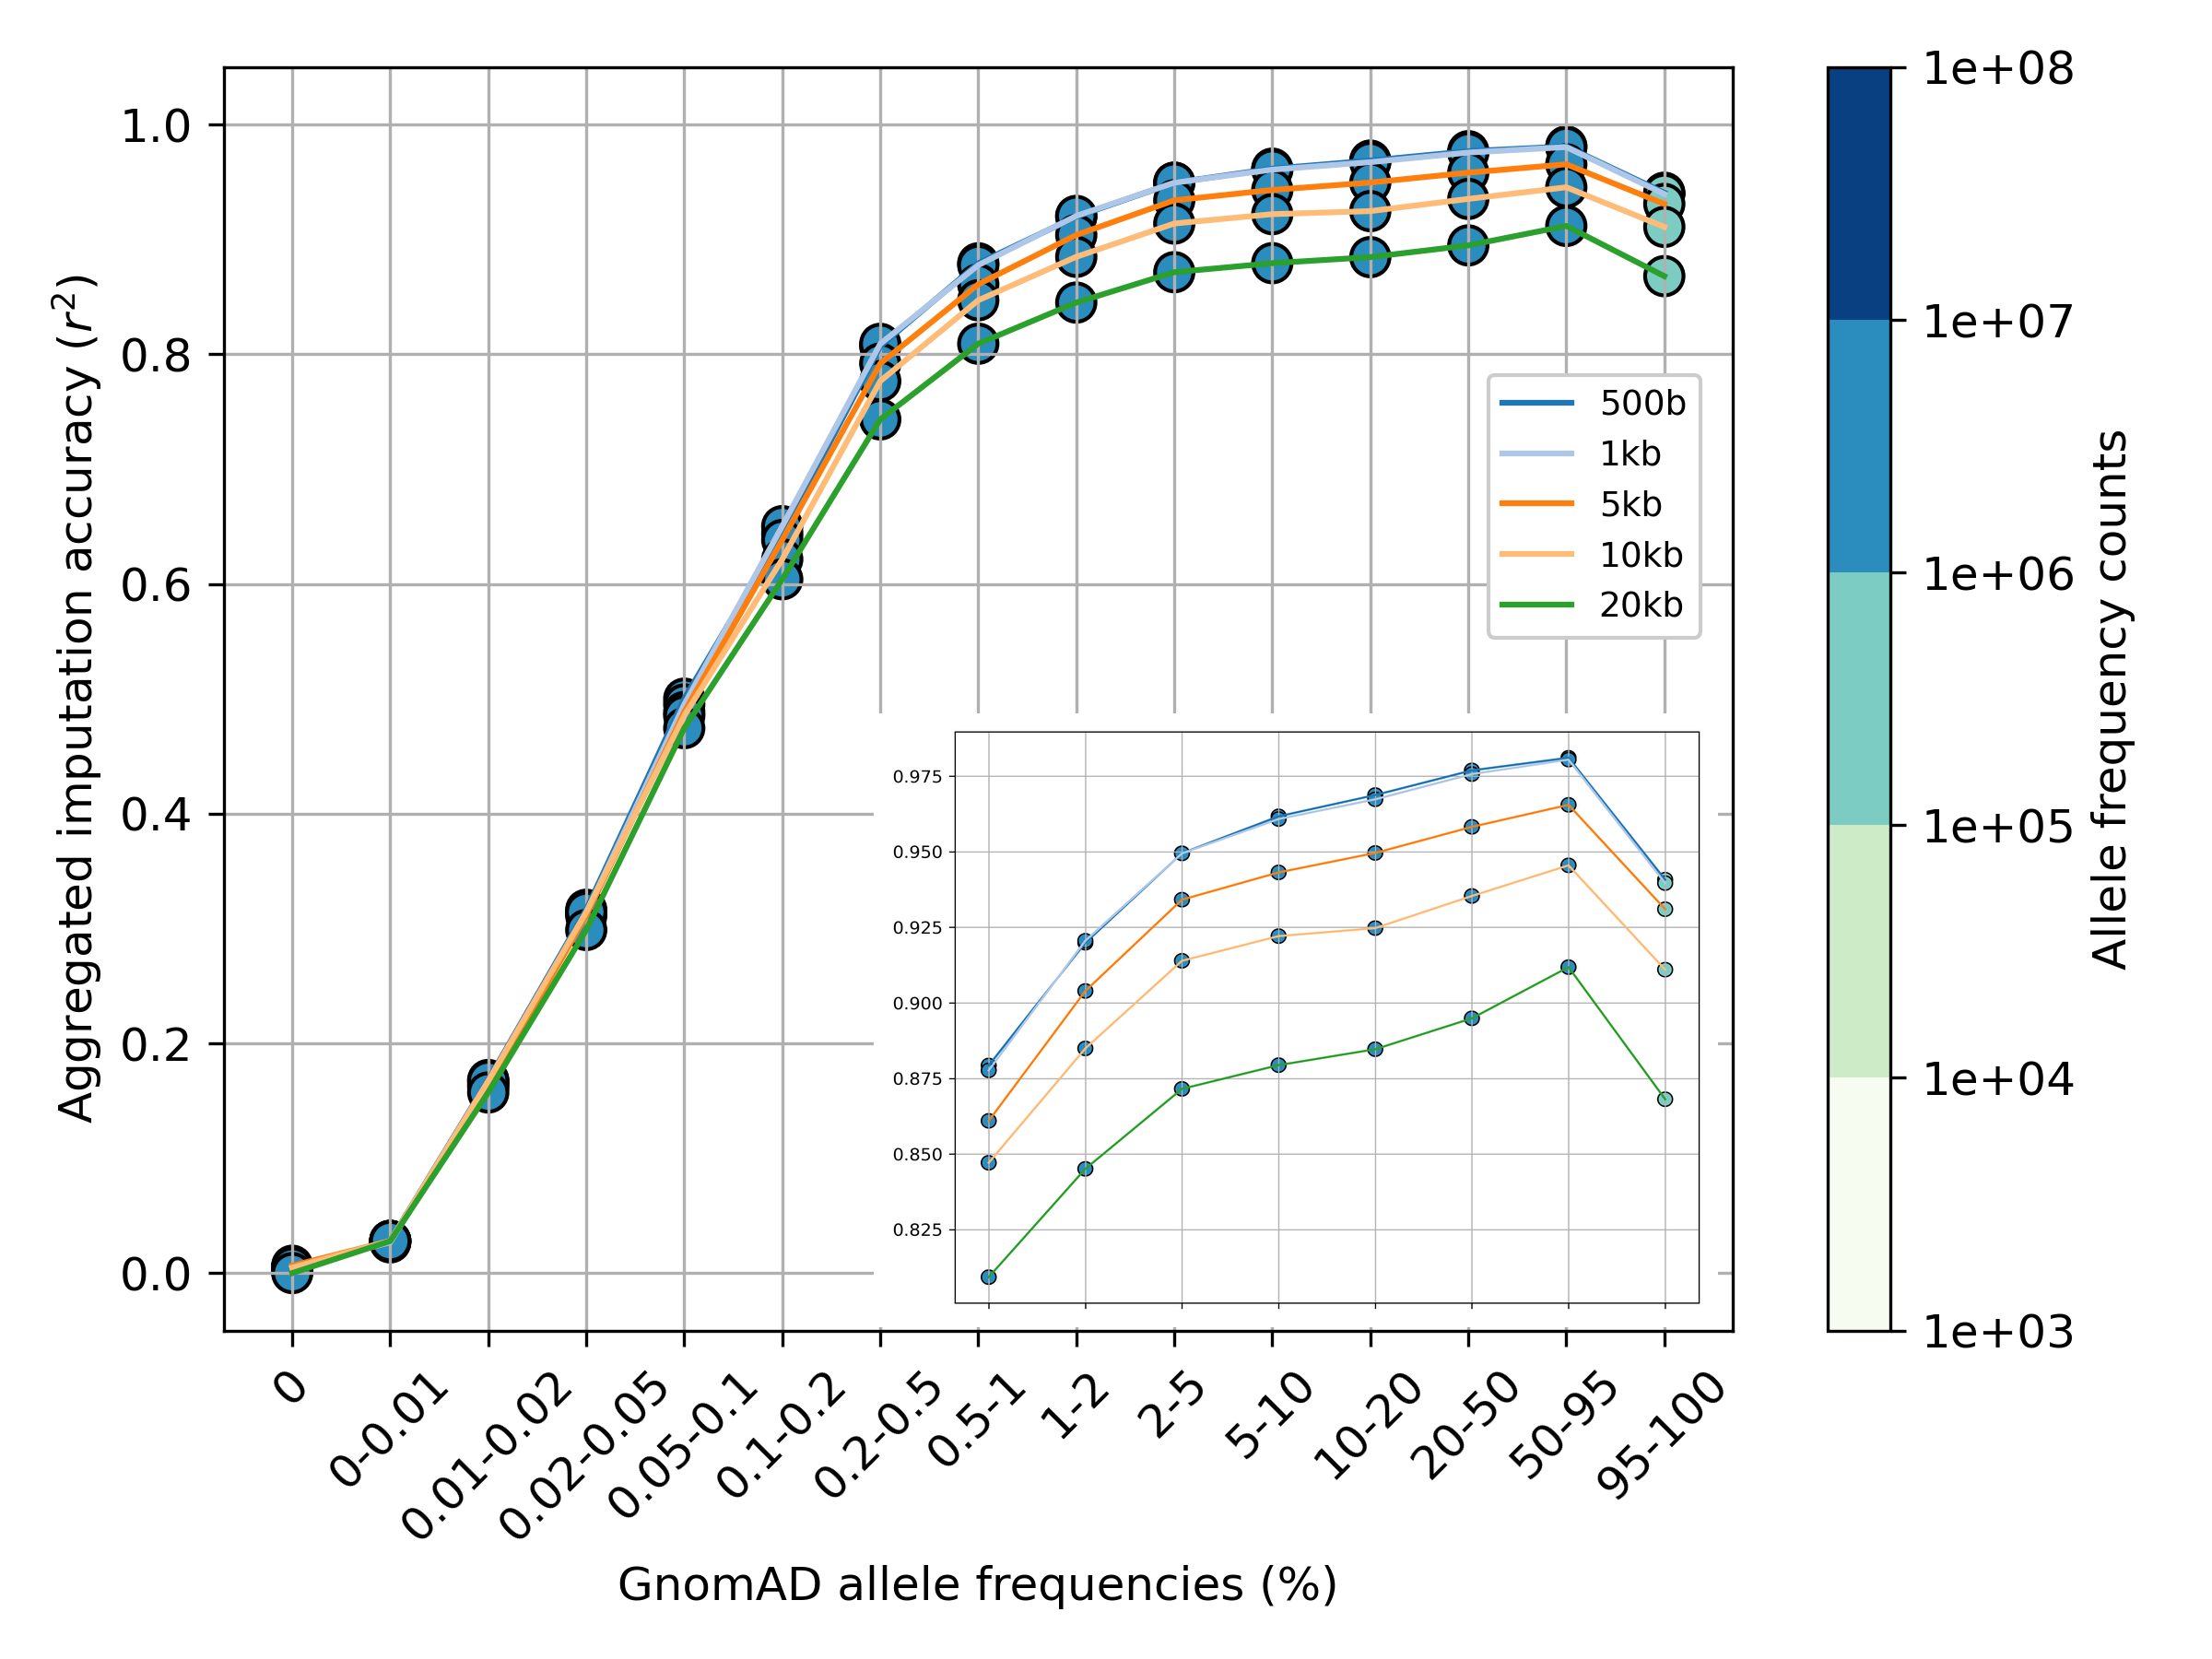

In [5]:
lr_rls = ['500b', '1kb', '5kb', '10kb', '20kb']

chrs = [pd.read_csv("/well/band/users/rbx225/GAMCC/results/imputation_comparison/lr_simulation/lc_oneKG--hc--snps_gw/impacc/all_samples/by_sample/chr" + i + ".v.tsv", sep = '\t') for i in CHROMOSOMES_ALL]

lr_ary = []
for r in lr_rls:
    lr_impaccs = []
    for df in chrs:
        lr_impaccs.append(df[df['sample'] == r].drop(columns = 'sample'))
    lr_ary.append(lcwgsus.average_impacc_by_chr(lr_impaccs))

dfs = lr_ary
labels = lr_rls
title = ''
t = 0.01

save_fig = True
save_prefix = 'sf4b'
res = lcwgsus.plot_imputation_accuracy_sequential([0, 1, 2, 3, 4], dfs, labels, title, t,
                                         save_fig = save_fig, outdir = outdir, save_prefix = save_prefix)
res[-1]

# SF5 HLA diversity

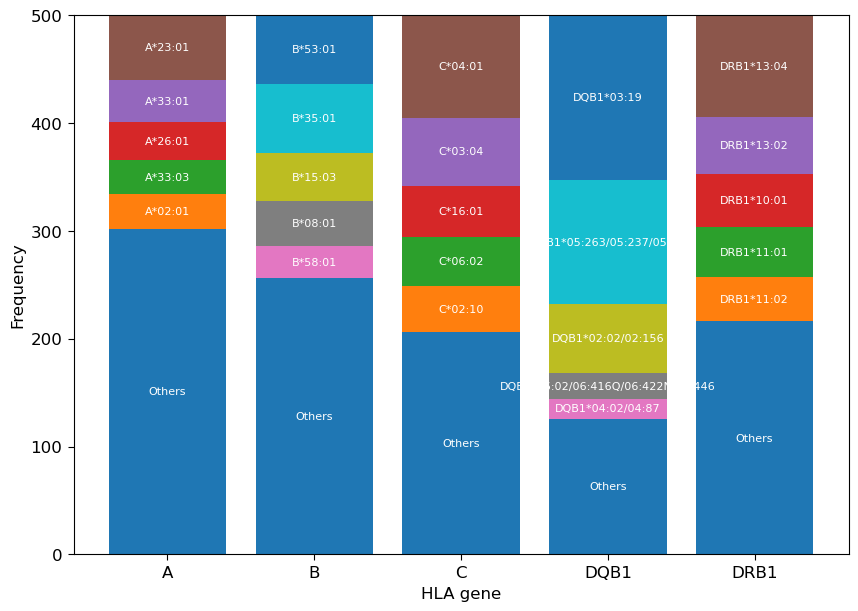

,Gene,Shannon Entropy,Number of distinct alleles,Number of ambiguous type from SBT
0,A,2.936754,25,0
1,B,3.103069,42,0
2,C,2.694756,25,0
3,DQB1,2.228746,23,294
4,DRB1,2.741211,31,90


In [6]:
hla = lcwgsus.read_hla_direct_sequencing()
hla_alleles_df = lcwgsus.gather_hla_alleles(hla)
lcwgsus.plot_hla_diversity(hla_alleles_df, save_fig = True, outdir = outdir, save_name = 'sf5.png')
summary = lcwgsus.calculate_hla_entropy(hla_alleles_df)
summary

# SF6 HLA imputation accuracy by alleles

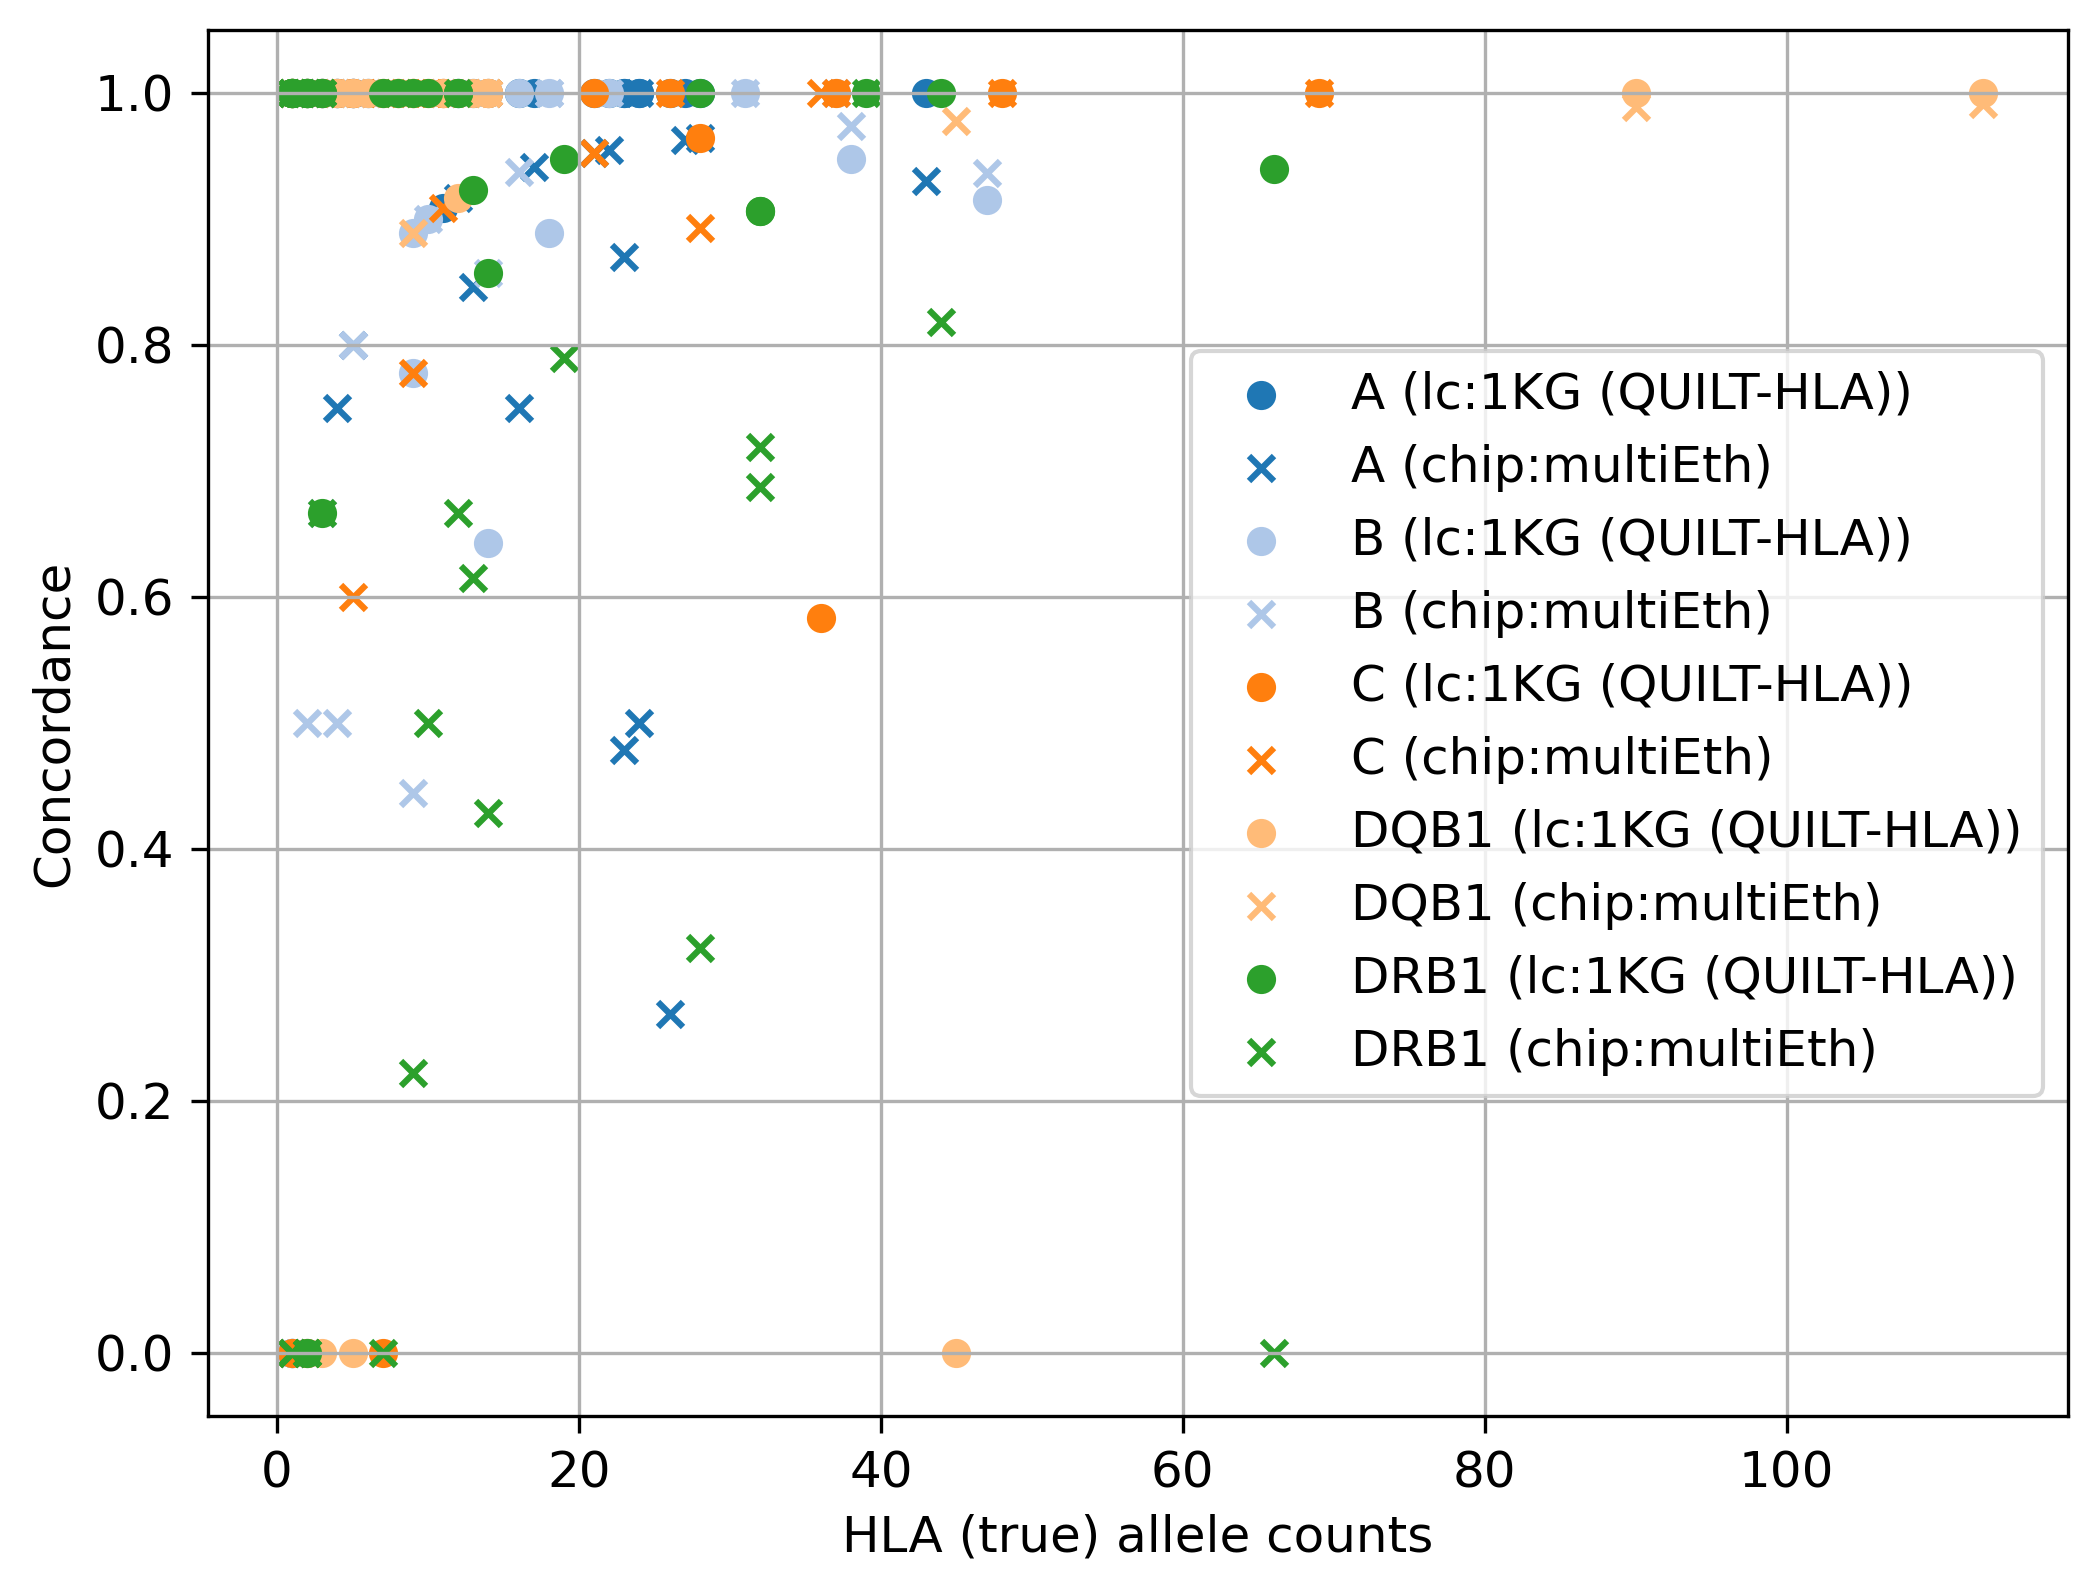

In [3]:
hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv')

hla_dirs = ['/well/band/users/rbx225/GAMCC/results/hla/imputation/batches_archived/',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/chip_vanilla/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_oneKG0.9/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_oneKG0.7/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_oneKG0.4/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_mGen0.9/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_mGen0.7/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_mGen0.4/chr6.dose.vcf.gz']

ix = [0,1]
hla_dir = [hla_dirs[i] for i in ix]
labels =  ['lc:1KG (QUILT-HLA)', 'chip:multiEth']

lcwgsus.plot_hla_imputation_accuracy_by_type(hla, hla_dir, labels, title = '', save_fig = save_fig, outdir = outdir, save_name = 'sf6.png')

In [4]:
lc = lcwgsus.read_hla_lc_imputation_results(hla_dirs[0], retain = 'fv')
chip = lcwgsus.read_hla_chip_imputation_results(hla_dirs[1], retain = 'fv')

ccd_dict_chip = lcwgsus.compare_hla_types_by_type(hla, chip)
ccd_dict_chip = lcwgsus.calculate_hla_concordance_by_type(ccd_dict_chip, verbose = False)

samples = chip['SampleID'].unique()
lc = lc[lc['SampleID'].isin(samples)].sort_values(by = ['SampleID', 'Locus'])

ccd_dict_lc = lcwgsus.compare_hla_types_by_type(hla, lc)
ccd_dict_lc = lcwgsus.calculate_hla_concordance_by_type(ccd_dict_lc, verbose = False)

In [6]:
ccd_dict_chip['DQB1']

,Accuracy,Sum,Match
02:02,0.000000,3,0
02:109/02:163N/02:202/02:148/02:112/02:198/02:01,1.000000,2,2
02:156/02:02,0.000000,45,0
02:202/02:163N/02:198/02:01,1.000000,11,11
02:203/02:02/02:156/02:199/02:131/02:175/02:110/02:187/02:97/02:165,0.000000,5,0
02:206N/02:118/02:125/02:142/02:138/02:202/02:163N/02:193/02:207/02:119/02:170/02:205/02:122/02:102/02:176N/02:137/02:203/02:210/02:182/02:111/02:158/02:175/02:209/02:06/02:189/02:195/02:165/02:169/02:128/02:04/02:131/02:106/02:199/02:121/02:190/02:126/02:133/02:96N/02:48/02:185/02:98/02:143/02:01/02:157/02:110/02:148/02:127/02:154/02:145/02:79/02:179/02:208/02:200/02:187/02:10/02:136/02:64/02:155/02:99/02:192/02:109/02:144/02:80/02:09/02:112/02:120/02:105/02:159/02:156/02:81/02:160/02:184/02:02/02:186/02:89/02:114/02:198/02:82/02:107/02:146/02:178/02:108/02:97/02:59,1.000000,1,1
03:01,1.000000,4,4
03:09,1.000000,6,6
03:19,1.000000,113,113
03:289/03:416/03:02/03:493/03:484,1.000000,8,8
